# dataset

In [1]:
import os
import torch
from tqdm import tqdm
import time

# declare which gpu device to use
cuda_device = '0'

def check_mem(cuda_device):
    devices_info = os.popen('"/usr/bin/nvidia-smi" --query-gpu=memory.total,memory.used --format=csv,nounits,noheader').read().strip().split("\n")
    total, used = devices_info[int(cuda_device)].split(',')
    return total,used

def occumpy_mem(cuda_device):
    total, used = check_mem(cuda_device)
    total = int(total)
    used = int(used)
    max_mem = int(total * 0.9)
    block_mem = max_mem - used
    x = torch.cuda.FloatTensor(256,1024,block_mem)
    del x
    
# if __name__ == '__main__':
os.environ["CUDA_VISIBLE_DEVICES"] = cuda_device
occumpy_mem(cuda_device)
for _ in tqdm(range(60)):
    time.sleep(1)
print('Done')

/home/bachnguyen/Desktop/projects/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  5%|▌         | 3/60 [00:03<01:08,  1.21s/it]


KeyboardInterrupt: 

In [1]:
import torch
print(torch.cuda.is_available())

True


/home/bachnguyen/Desktop/projects/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from PIL import Image
import cv2

import numpy as np
import os
import glob

import skimage
from skimage.restoration import denoise_tv_chambolle

print(torch.__version__)


# transform = {
#     'train': transforms.Compose([
#         transforms.ToTensor()
#     ])
# }

# base_dir = "./datasets"
# data = torchvision.datasets.ImageFolder(root=f"{base_dir}/train/training", transform=transform['train'])
# data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=16, shuffle=False)

# batch_idx = 0

# for batch in next(iter(data_loader)):
#     img, label = batch
#     print(f"[{batch_idx}]: {img.shape} - {label.shape}")
#     if batch_idx == 0:
#         print(img)
#         print(label)
#     batch_idx += 1

class EyeBlinkDataset(torch.utils.data.Dataset):
    def __init__(self, train=True, use_threshold=0, threshold=96):
        if train:
            self.seq_list = sorted(glob.glob('datasets/train/training/blink/*'), key=lambda x: int(x.split('/')[-1]))
            self.seq_list.extend(sorted(glob.glob('datasets/train/training/unblink/*'), key=lambda x: int(x.split('/')[-1])))
        else:
            self.seq_list = sorted(glob.glob('datasets/test/test/blink/*'), key=lambda x: int(x.split('/')[-1]))
            self.seq_list.extend(sorted(glob.glob('datasets/test/test/unblink/*'), key=lambda x: int(x.split('/')[-1])))

        ## remove frames without left/right eye
        tmp = []; idx_list = []
        for i, seq in enumerate(self.seq_list):
            frames_fnames = sorted(glob.glob(f'{seq}/13/zuo/*'))
            # print(seq, len(frames_fnames))
            if len(frames_fnames) == 0:
                idx_list.append(i)
                tmp.append(seq)
        for i in sorted(idx_list, reverse=True):
            del self.seq_list[i]
        print(tmp)

        ## remove frames smaller/larger than threshold
        if use_threshold != 0:
            idx_list = []
            for i, seq in enumerate(self.seq_list):
                frames_fnames = sorted(glob.glob(f'{seq}/13/zuo/*'), key=lambda x: int(x.split('/')[-1].replace('eye_zuo.bmp','')) )
                
                min_size = 9999; max_size=0
                for fname in frames_fnames:
                    frame = Image.open(fname)
                    if frame.size[0] <= min_size: min_size = frame.size[0]
                    if frame.size[0] >= max_size: max_size = frame.size[0]
                
                if use_threshold == -1 and max_size > threshold or use_threshold == 1 and min_size < threshold:
                    # print(i, ' - heyyy 1 - ', seq, min_size, max_size)
                    idx_list.append(i)
                # else:
                    # print(i, ' - heyyy 2- ',seq, min_size, max_size)
            # print('heyyy', idx_list)
            for i in sorted(idx_list, reverse=True):
                del self.seq_list[i]

        self.resize = transforms.Resize([96,96]) #[96,96])
        self.to_tensor = transforms.ToTensor()
        self.sizes = []
        self.train = train

    def __len__(self):
        return len(self.seq_list)

    def __getitem__(self, idx):
        # print(self.seq_list[idx])
        frames_fnames = sorted(glob.glob(f'{self.seq_list[idx]}/13/zuo/*'), key=lambda x: int(x.split('/')[-1].replace('eye_zuo.bmp','')) )
        frames_data = np.zeros((96,96,13,3)) #np.zeros((96,96,13,3))

        for i, fname in enumerate(frames_fnames):
            frame = Image.open(fname)
            self.sizes.append(frame.size[0])
            #frame = self.resize(frame)
            frame = np.array(frame)
            if frame.shape[0] < 96: frame = cv2.resize(frame, (96,96), interpolation=cv2.INTER_CUBIC)
            if frame.shape[0] > 96: frame = cv2.resize(frame, (96,96), interpolation=cv2.INTER_LINEAR)

            #frame = denoise_tv_chambolle(frame, weight=0.1, channel_axis=-1)
            #frame = skimage.transform.resize(frame, (48,48))
            frame = frame / 255.0
            frames_data[:,:,i,:] = frame
        
        label = 1 if "/blink/" in self.seq_list[idx] else 0
        return frames_data, label

/home/bachnguyen/Desktop/projects/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.0+cu113


In [ ]:
'''
import torch
import torchvision
import torchvision.transforms as transforms

from PIL import Image
import cv2

import numpy as np
import os
import glob

import skimage
from skimage.restoration import denoise_tv_chambolle


class EyeBlinkDataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        if train:
            self.seq_list = sorted(glob.glob('datasets/train/training/blink/*'), key=lambda x: int(x.split('/')[-1]))
            self.seq_list.extend(sorted(glob.glob('datasets/train/training/unblink/*'), key=lambda x: int(x.split('/')[-1])))
        else:
            self.seq_list = sorted(glob.glob('datasets/test/test/blink/*'), key=lambda x: int(x.split('/')[-1]))
            self.seq_list.extend(sorted(glob.glob('datasets/test/test/unblink/*'), key=lambda x: int(x.split('/')[-1])))

        ## remove frames without left/right eye
        tmp = []; idx_list = []
        for i, seq in enumerate(self.seq_list):
            frames_fnames = sorted(glob.glob(f'{seq}/13/zuo/*'))
            # print(seq, len(frames_fnames))
            if len(frames_fnames) == 0:
                idx_list.append(i)
                tmp.append(seq)
        for i in sorted(idx_list, reverse=True):
            del self.seq_list[i]
        print(tmp)

        self.resize = transforms.Resize([96,96]) #[96,96])
        self.to_tensor = transforms.ToTensor()
        self.sizes = []

    def __len__(self):
        return len(self.seq_list)

    def __getitem__(self, idx):
        frames_fnames = sorted(glob.glob(f'{self.seq_list[idx]}/13/zuo/*'), key=lambda x: int(x.split('/')[-1].replace('eye_zuo.bmp','')) )
        frames_data = np.zeros((96,96,13,3)) #np.zeros((96,96,13,3))

        for i, fname in enumerate(frames_fnames):
            frame = Image.open(fname)
            self.sizes.append(frame.size[0])
            #frame = self.resize(frame)
            frame = np.array(frame)
            frame = cv2.resize(frame, (96,96), interpolation=cv2.INTER_CUBIC)
            #frame = denoise_tv_chambolle(frame, weight=0.1, channel_axis=-1)
            #frame = skimage.transform.resize(frame, (48,48))
            frame = frame / 255.0
            frames_data[:,:,i,:] = frame
        
        label = 1 if "/blink/" in self.seq_list[idx] else 0
        return frames_data, label
'''

# model

In [2]:
import torch.nn as nn

class Conv1x1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv1x1, self).__init__()
        self.conv1x1 = nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,1,1), stride=(1,2,2), padding=(1,0,0))
        self.batchnorm = nn.BatchNorm3d(num_features = out_channels)
    
    def forward(self, x):
        x = self.conv1x1(x)
        x = self.batchnorm(x)
        return x

class Conv3x3(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv3x3, self).__init__()
        self.conv3x3 = nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3,3), stride=(1,1,1), padding=(1,1,1))
        self.batchnorm = nn.BatchNorm3d(num_features=out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv3x3(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

class Conv5x5(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv5x5, self).__init__()
        self.conv5x5 = nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,5,5), stride=(1,1,1), padding=(1,2,2))
        self.batchnorm = nn.BatchNorm3d(num_features=out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv5x5(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

class PyramidBlock2B(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PyramidBlock2B, self).__init__()
        self.branch1 = Conv1x1(in_channels=in_channels, out_channels=out_channels)
        self.branch2 = nn.Sequential(
            Conv3x3(in_channels=in_channels, out_channels=out_channels),
            Conv1x1(in_channels=out_channels, out_channels=out_channels)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x = torch.add(x1,x2)
        x = self.relu(x)
        return x

class PyramidBlock3B(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PyramidBlock3B, self).__init__()
        self.branch1 = Conv1x1(in_channels=in_channels, out_channels=out_channels)
        self.branch2 = nn.Sequential(
            Conv3x3(in_channels=in_channels, out_channels=out_channels),
            Conv1x1(in_channels=out_channels, out_channels=out_channels)
        )
        self.branch3 = nn.Sequential(
            Conv5x5(in_channels=in_channels, out_channels=out_channels),
            Conv3x3(in_channels=out_channels, out_channels=out_channels),
            Conv1x1(in_channels=out_channels, out_channels=out_channels)
        )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x = x1+x2+x3
        x = self.relu(x)
        return x

class ConvInput(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvInput, self).__init__()
        self.conv3x3 = nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3,3), stride=(2,1,1), padding=(1,1,1))
        self.batchnorm = nn.BatchNorm3d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool3d(kernel_size=(3,3,3), stride=(2,1,1), padding=(1,1,1))
    
    def forward(self, x):
        x = self.conv3x3(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x


class P2B2(nn.Module):
    def __init__(self, in_channels=3, mid_channels=64):
        super(P2B2, self).__init__()
        self.conv_input = ConvInput(in_channels=in_channels, out_channels=mid_channels)
        self.block1 = PyramidBlock2B(in_channels=mid_channels, out_channels=mid_channels)
        self.block2 = PyramidBlock2B(in_channels=mid_channels, out_channels=mid_channels*2)
        self.avgpool = nn.AvgPool3d(kernel_size=(4,24,24)) #nn.AvgPool3d(kernel_size=(4,24,24))

        self.linear = nn.Linear(128,2)
    
    def forward(self, x):
        x = self.conv_input(x)
        # print(x.shape)
        x = self.block1(x)
        # print(x.shape)
        x = self.block2(x)
        # print(x.shape)
        x = self.avgpool(x)
        # print(x.shape)
        x = x.squeeze()
        x = self.linear(x)
        return x

class P3B3(nn.Module):
    def __init__(self, in_channels=3, mid_channels=64):
        super(P3B3, self).__init__()
        self.conv_input = ConvInput(in_channels=in_channels, out_channels=mid_channels)
        self.block1 = PyramidBlock3B(in_channels=mid_channels, out_channels=mid_channels)
        self.block2 = PyramidBlock3B(in_channels=mid_channels, out_channels=mid_channels*2)
        self.block3 = PyramidBlock3B(in_channels=mid_channels*2, out_channels=mid_channels*4)
        self.avgpool = nn.AvgPool3d(kernel_size=(4,12,12))
        self.linear = nn.Linear(256,2)
    
    def forward(self, x):
        x = self.conv_input(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.avgpool(x)
        x = x.squeeze()
        x = self.linear(x)
        return x

# class P4B3(nn.Module):
#         def __init__(self, in_channels=3, mid_channels=64):
#             super(P4B3, self).__init__()
#             self.conv_input = ConvInput(in_channels=in_channels, out_channels=mid_channels)
#             self.block1 = PyramidBlock3B(in_)

# model - depthwise & pointwise

In [3]:
import torch.nn as nn

class Conv1x1_Separable(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv1x1_Separable, self).__init__()
        self.conv1_dw = nn.Conv3d(in_channels=in_channels, out_channels=in_channels, kernel_size=(3,1,1), stride=(1,2,2), padding=(1,0,0), groups=in_channels)
        self.batchnorm1 = nn.BatchNorm3d(num_features = in_channels)
        self.relu = nn.ReLU()
        self.conv2_pw = nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1,1,1), stride=(1,1,1), padding=0)
        self.batchnorm2 = nn.BatchNorm3d(num_features= out_channels)
    
    def forward(self, x):
        # x = self.conv1_dw(x)
        # x = self.batchnorm1(x)
        # x = self.relu(x)
        # x = self.conv2_pw(x)
        # x = self.batchnorm2(x)
        x = self.batchnorm2(self.conv2_pw(self.relu(self.batchnorm1(self.conv1_dw(x)))))
        return x

class Conv3x3_Separable(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv3x3_Separable, self).__init__()
        self.conv1_dw = nn.Conv3d(in_channels=in_channels, out_channels=in_channels, kernel_size=(3,3,3), stride=(1,1,1), padding=(1,1,1), groups=in_channels)
        self.batchnorm1 = nn.BatchNorm3d(num_features=in_channels)
        self.relu = nn.ReLU()
        self.conv2_pw = nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1,1,1), stride=(1,1,1), padding=0)
        self.batchnorm2 = nn.BatchNorm3d(num_features=out_channels)
    
    def forward(self, x):
        # x = self.conv1_dw(x)
        # x = self.batchnorm1(x)
        # x = self.relu(x)
        # x = self.conv2_pw(x)
        # x = self.batchnorm2(x)
        # x = self.relu(x)
        x = self.relu(self.batchnorm2(self.conv2_pw(self.relu(self.batchnorm1(self.conv1_dw(x))))))
        return x

class Conv5x5_Separable(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv5x5_Separable, self).__init__()
        self.conv1_dw = nn.Conv3d(in_channels=in_channels, out_channels=in_channels, kernel_size=(3,5,5), stride=(1,1,1), padding=(1,2,2), groups=in_channels)
        self.batchnorm1 = nn.BatchNorm3d(num_features=in_channels)
        self.relu = nn.ReLU()
        self.conv2_pw = nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1,1,1), stride=(1,1,1), padding=0 )
        self.batchnorm2 = nn.BatchNorm3d(num_features=out_channels)
    
    def forward(self, x):
        # x = self.conv1_dw(x)
        # x = self.batchnorm1(x)
        # x = self.relu(x)
        # x = self.conv2_pw(x)
        # x = self.batchnorm2(x)
        # x = self.relu(x)
        x = self.relu(self.batchnorm2(self.conv2_pw(self.relu(self.batchnorm1(self.conv1_dw(x))))))
        return x

class PyramidBlock2B_SeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PyramidBlock2B_SeparableConv, self).__init__()
        self.branch1 = Conv1x1_Separable(in_channels=in_channels, out_channels=out_channels)
        self.branch2 = nn.Sequential(
            Conv3x3_Separable(in_channels=in_channels, out_channels=out_channels),
            Conv1x1_Separable(in_channels=out_channels, out_channels=out_channels)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x = torch.add(x1,x2)
        x = self.relu(x)
        return x

class PyramidBlock3B_SeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PyramidBlock3B_SeparableConv, self).__init__()
        self.branch1 = Conv1x1_Separable(in_channels=in_channels, out_channels=out_channels)
        self.branch2 = nn.Sequential(
            Conv3x3_Separable(in_channels=in_channels, out_channels=out_channels),
            Conv1x1_Separable(in_channels=out_channels, out_channels=out_channels)
        )
        self.branch3 = nn.Sequential(
            Conv5x5_Separable(in_channels=in_channels, out_channels=out_channels),
            Conv3x3_Separable(in_channels=out_channels, out_channels= out_channels),
            Conv1x1_Separable(in_channels=out_channels, out_channels=out_channels)
        )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # x1 = self.branch1(x)
        # x2 = self.branch2(x)
        # x3 = self.branch3(x)
        # x = x1 + x2 + x3
        # x = self.relu(x)
        x = self.relu(self.branch1(x)+self.branch2(x)+self.branch3(x))
        return x


class ConvInput(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvInput, self).__init__()
        self.conv3x3 = nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3,3), stride=(2,1,1), padding=(1,1,1))
        self.batchnorm = nn.BatchNorm3d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool3d(kernel_size=(3,3,3), stride=(2,1,1), padding=(1,1,1))
    
    def forward(self, x):
        x = self.conv3x3(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x


class P2B2_SeparableConv(nn.Module):
    def __init__(self, in_channels=3, mid_channels=64):
        super(P2B2_SeparableConv, self).__init__()
        self.conv_input = ConvInput(in_channels=in_channels, out_channels=mid_channels)
        self.block1 = PyramidBlock2B_SeparableConv(in_channels=mid_channels, out_channels=mid_channels)
        self.block2 = PyramidBlock2B_SeparableConv(in_channels=mid_channels, out_channels=mid_channels*2)
        self.avgpool = nn.AvgPool3d(kernel_size=(4,24,24)) #nn.AvgPool3d(kernel_size=(4,24,24))

        self.linear = nn.Linear(128,2)
    
    def forward(self, x):
        x = self.conv_input(x)
        # print(x.shape)
        x = self.block1(x)
        # print(x.shape)
        x = self.block2(x)
        # print(x.shape)
        x = self.avgpool(x)
        # print(x.shape)
        x = x.squeeze()
        x = self.linear(x)
        return x

class P3B3_SeparableConv(nn.Module):
    def __init__(self, in_channels=3, mid_channels=64):
        super(P3B3_SeparableConv, self).__init__()
        self.conv_input = ConvInput(in_channels=in_channels, out_channels=mid_channels)
        self.block1 = PyramidBlock3B_SeparableConv(in_channels=mid_channels, out_channels=mid_channels)
        self.block2 = PyramidBlock3B_SeparableConv(in_channels=mid_channels, out_channels=mid_channels*2)
        self.block3 = PyramidBlock3B_SeparableConv(in_channels=mid_channels*2, out_channels=mid_channels*4)
        self.avgpool = nn.AvgPool3d(kernel_size=(4,12,12))

        self.linear = nn.Linear(256, 2)
    
    def forward(self, x):
        # x = self.conv_input(x)
        # x = self.block1(x)
        # x = self.block2(x)
        # x = self.block3(x)
        # x = self.avgpool(x)
        # x = x.squeeze()
        # x = self.linear(x)
        x = self.linear(self.avgpool(self.block3(self.block2(self.block1(self.conv_input(x))))).squeeze())
        return x
        

# training

In [5]:
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

tb = SummaryWriter()

def get_num_correct(preds_logits, labels):
    return (preds_logits.argmax(dim=1) == labels).sum().item()

device = torch.device('cuda:0')

data = EyeBlinkDataset(train=True)
data_loader = torch.utils.data.DataLoader(data, batch_size=13, shuffle=True)

print(len(data))

# model = P2B2().double()
model = P2B2_SeparableConv().double()
# model = P3B3().double()
# model = P3B3_SeparableConv().double()
model.to(device)
model.train()

# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters()) #, lr=0.003)

min_loss = float('inf')
num_epochs = 200

EYE = 'left'

for epoch in range(num_epochs):
    avg_loss = 0
    total_correct = 0

    for seqs, labels in data_loader:
        seqs = seqs.permute((0,4,3,1,2)).to(device)
        labels = labels.to(device)

        preds_logits = model(seqs)
        loss = F.cross_entropy(preds_logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.detach().item() / len(data_loader)
        total_correct += get_num_correct(preds_logits, labels)

    if avg_loss < min_loss:
        min_loss = avg_loss
        # torch.save(model, f'checkpoints/{EYE}/P2B2-num_epochs_{num_epochs}.pt')
        torch.save(model, f'checkpoints/{EYE}/P2B2_SeparableConv-num_epochs_{num_epochs}.pt')
        # torch.save(model, f'checkpoints/{EYE}/P3B3-num_epochs_{num_epochs}.pt')
        # torch.save(model, f'checkpoints/{EYE}/P3B3_SeparableConv-num_epochs_{num_epochs}.pt')

    tb.add_scalar('Loss', avg_loss, epoch)
    tb.add_scalar('Number correct', total_correct, epoch)
    tb.add_scalar('Accuracy', total_correct/len(data), epoch)
    print(f'epoch: {epoch} - train_acc: {total_correct/len(data)} - loss: {avg_loss} - min_loss: {min_loss}')


2023-02-13 13:25:36.841857: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 13:25:36.935592: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-13 13:25:36.956633: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-13 13:25:37.292657: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

['datasets/train/training/blink/8', 'datasets/train/training/blink/141', 'datasets/train/training/blink/142', 'datasets/train/training/blink/151', 'datasets/train/training/blink/152', 'datasets/train/training/blink/153', 'datasets/train/training/blink/154', 'datasets/train/training/blink/155', 'datasets/train/training/blink/158', 'datasets/train/training/blink/159', 'datasets/train/training/blink/160', 'datasets/train/training/blink/179', 'datasets/train/training/blink/181', 'datasets/train/training/blink/182', 'datasets/train/training/blink/198', 'datasets/train/training/unblink/55', 'datasets/train/training/unblink/61', 'datasets/train/training/unblink/76', 'datasets/train/training/unblink/78', 'datasets/train/training/unblink/79', 'datasets/train/training/unblink/80', 'datasets/train/training/unblink/82', 'datasets/train/training/unblink/83', 'datasets/train/training/unblink/93', 'datasets/train/training/unblink/94', 'datasets/train/training/unblink/95', 'datasets/train/training/unb

# training - k fold cross validation


In [ ]:
import torch.optim as optim
import torch.nn.functional as F


from torch.utils.tensorboard import SummaryWriter

tb = SummaryWriter()


from sklearn.model_selection import KFold

import os
import random
import numpy as np
import torch

def fixed_seed(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set `pytorch` pseudo-random generator at a fixed value
    torch.manual_seed(seed_value)


def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

def get_num_correct(preds_logits, labels):
    return (preds_logits.argmax(dim=1) == labels).sum().item()

device = torch.device('cuda:0')

# fixed_seed(42)


data = EyeBlinkDataset(train=True)
# data_loader = torch.utils.data.DataLoader(data, batch_size=16, shuffle=True)

print(len(data))


kfold = KFold(n_splits=5, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(data)):
    print(f'{fold}: ')
    print(f'train_ids: {train_ids}')
    print(f'val_ids: {val_ids}')
    train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_ids)
    
    train_loader = torch.utils.data.DataLoader(data, batch_size=16, sampler= train_sampler)
    val_loader = torch.utils.data.DataLoader(data, batch_size=16, sampler= val_sampler)


model = P2B2().double()
model.to(device)
model.train()

# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

min_loss = float('inf')
num_epochs = 500

for epoch in range(num_epochs):
    total_loss = 0
    total_correct = 0

    for seqs, labels in data_loader:
        seqs = seqs.permute((0,4,3,1,2)).to(device)
        labels = labels.to(device)

        preds_logits = model(seqs)
        loss = F.cross_entropy(preds_logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.detach().item()
        total_correct += get_num_correct(preds_logits, labels)

    if total_loss < min_loss:
        min_loss = total_loss
        torch.save(model, f'checkpoints/P2B2-num_epochs_{num_epochs}.pt')

    tb.add_scalar('Loss', total_loss, epoch)
    tb.add_scalar('Number correct', total_correct, epoch)
    tb.add_scalar('Accuracy', total_correct/len(data), epoch)
    print(f'epoch: {epoch} - train_acc: {total_correct/len(data)} - loss: {total_loss} - min_loss: {min_loss}')



# training - EarlyStopping + k-fold cross validation

In [3]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.fname = 'checkpoints/P2B2_SeparableConv.pt'

    def __call__(self, val_loss, model, fname):
        
        self.fname = fname

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.fname)
        self.val_loss_min = val_loss



def get_num_correct(preds_logits, labels):
    return (preds_logits.argmax(dim=1) == labels).sum().item()

def count_TP(preds_logits, labels):
    preds = preds_logits.argmax(dim=1)
    tmp = torch.add(preds, labels)
    return (tmp == 2).sum().item()

def count_TN(preds_logits, labels):
    preds = preds_logits.argmax(dim=1)
    tmp = torch.add(preds, labels)
    return (tmp == 0).sum().item()

def count_FP(preds_logits, labels):
    preds = preds_logits.argmax(dim=1)
    tmp = torch.subtract(preds, labels)
    return (tmp == 1).sum().item()

def count_FN(preds_logits, labels):
    preds = preds_logits.argmax(dim=1)
    tmp = torch.subtract(preds, labels)
    return (tmp == -1).sum().item()



import os
import random
import numpy as np
import torch

def fixed_seed(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set `pytorch` pseudo-random generator at a fixed value
    torch.manual_seed(seed_value)

fixed_seed(42)


import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import KFold

device = torch.device('cuda:0')

data = EyeBlinkDataset(train=True)
data_test = EyeBlinkDataset(train=False)

test_results = []

EYE = 'right'

kfold = KFold(n_splits=15, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(data)):
    print(f'\n[Fold {fold}]: ')
    train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_ids)
    train_loader = torch.utils.data.DataLoader(data, batch_size=13, sampler=train_sampler, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(data, batch_size=13, sampler=val_sampler, pin_memory=True)
    print(f'len(train_sampler)={len(train_sampler)}')
    print(f'len(val_sampler)={len(val_sampler)}')
    print(val_ids)

    # model = P2B2().double()
    model = P2B2_SeparableConv().double()
    # model = P3B3().double()
    # model = P3B3_SeparableConv().double()
    model.to(device)

    # loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    min_loss = float('inf')
    num_epochs = 500

    early_stopping = EarlyStopping(patience=50, verbose=True)

    for epoch in range(num_epochs):
        ## train set
        avg_train_loss = 0
        total_train_correct = 0
        model.train()

        for seqs, labels in train_loader:
            seqs = seqs.permute((0,4,3,1,2)).to(device)
            labels = labels.to(device)

            preds_logits = model(seqs)
            
            # print('---',seqs.shape)
            # print(preds_logits.shape)
            # print(labels.shape,'---')
        
            loss = F.cross_entropy(preds_logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_train_loss += loss.detach().item() / len(train_loader)
            total_train_correct += get_num_correct(preds_logits, labels)

        ## val set
        with torch.no_grad():
            model.eval()
            avg_val_loss = 0
            total_val_correct = 0

            for seqs, labels in val_loader:
                seqs = seqs.permute((0,4,3,1,2)).to(device)
                labels = labels.to(device)

                preds = model(seqs)
                loss = F.cross_entropy(preds, labels)
                avg_val_loss += loss.detach().item() / len(val_loader)
                total_val_correct += get_num_correct(preds, labels) 

        early_stopping(avg_val_loss, model, f'checkpoints/{EYE}/P2B2_SeparableConv-fold_{fold}.pt')
        # early_stopping(avg_val_loss, model, f'checkpoints/{EYE}/P2B2-fold_{fold}.pt')
        # early_stopping(avg_val_loss, model, f'checkpoints/{EYE}/P3B3-fold_{fold}.pt')
        # early_stopping(avg_val_loss, model, f'checkpoints/{EYE}/P3B3_SeparableConv-fold_{fold}.pt')

        print(f'epoch: {epoch} - train_acc: {total_train_correct/len(train_sampler)} - train_loss: {avg_train_loss} - val_acc: {total_val_correct/len(val_sampler)} - val_loss: {avg_val_loss}')

        if early_stopping.early_stop:
            print('=> Early stopped !!')
            break
    

    ## test set
    with torch.no_grad():
        data_test_loader = torch.utils.data.DataLoader(data_test, batch_size=13, shuffle=True, pin_memory=True)
        # model.load_state_dict(torch.load(f'checkpoints/{EYE}/P2B2-fold_{fold}.pt'))
        model.load_state_dict(torch.load(f'checkpoints/{EYE}/P2B2_SeparableConv-fold_{fold}.pt'))
        # model.load_state_dict(torch.load(f'checkpoints/{EYE}/P3B3-fold_{fold}.pt'))
        # model.load_state_dict(torch.load(f'checkpoints/{EYE}/P3B3_SeparableConv-fold_{fold}.pt'))
        model.eval()
        
        total_TP = 0
        total_TN = 0
        total_FP = 0
        total_FN = 0

        for seqs, labels in data_test_loader:
            seqs = seqs.permute((0,4,3,1,2)).to(device)
            labels = labels.to(device)

            preds = model(seqs)
            total_TP += count_TP(preds, labels)
            total_TN += count_TN(preds, labels)
            total_FP += count_FP(preds, labels)
            total_FN += count_FN(preds, labels)
    
    accuracy  = (total_TP + total_TN)  / len(data_test)
    precision = total_TP / (total_TP + total_FP)
    recall    = total_TP / (total_TP + total_FN)
    F1        = 2 / ((1 / precision) + (1 / recall))
    print(f"Accuracy: {accuracy}")
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {F1}')
    
    result = {'acc':accuracy, 'pre':precision, 'rec': recall, 'f1': F1}
    test_results.append(result)

import json

with open(f'checkpoints/{EYE}/P2B2_SeparableConv-results.txt','w') as fp:
# with open(f'checkpoints/{EYE}/P2B2-results.txt','w') as fp:
# with open(f'checkpoints/{EYE}/P3B3-results.txt','w') as fp:
# with open(f'checkpoints/{EYE}/P3B3_SeparableConv-results.txt','w') as fp:
    fp.write(json.dumps(test_results))

['datasets/train/training/blink/147', 'datasets/train/training/blink/223', 'datasets/train/training/unblink/54', 'datasets/train/training/unblink/57', 'datasets/train/training/unblink/59', 'datasets/train/training/unblink/99', 'datasets/train/training/unblink/100']
['datasets/test/test/blink/105']

[Fold 0]: 
len(train_sampler)=411
len(val_sampler)=30
[  9  30  39  73  75  77  78 116 117 124 131 137 152 155 198 204 237 246
 278 280 281 362 383 388 394 396 398 406 436 439]
Validation loss decreased (inf --> 0.649581).  Saving model ...
epoch: 0 - train_acc: 0.5936739659367397 - train_loss: 0.6938355466396197 - val_acc: 0.6 - val_loss: 0.6495814942339381
Validation loss decreased (0.649581 --> 0.534563).  Saving model ...
epoch: 1 - train_acc: 0.6520681265206812 - train_loss: 0.6185480922320316 - val_acc: 0.7666666666666667 - val_loss: 0.5345626007442147
Validation loss decreased (0.534563 --> 0.480625).  Saving model ...
epoch: 2 - train_acc: 0.6715328467153284 - train_loss: 0.601223735

In [4]:
with open(f'checkpoints/{EYE}/P3B3_SeparableConv-results.txt','w') as fp:
    fp.write(json.dumps(test_results))

# training - gradient accumulation - EarlyStopping + k-fold

In [3]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.fname = 'checkpoints/P2B2_SeparableConv.pt'

    def __call__(self, val_loss, model, fname):
        
        self.fname = fname

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.fname)
        self.val_loss_min = val_loss



def get_num_correct(preds_logits, labels):
    return (preds_logits.argmax(dim=1) == labels).sum().item()

def count_TP(preds_logits, labels):
    preds = preds_logits.argmax(dim=1)
    tmp = torch.add(preds, labels)
    return (tmp == 2).sum().item()

def count_TN(preds_logits, labels):
    preds = preds_logits.argmax(dim=1)
    tmp = torch.add(preds, labels)
    return (tmp == 0).sum().item()

def count_FP(preds_logits, labels):
    preds = preds_logits.argmax(dim=1)
    tmp = torch.subtract(preds, labels)
    return (tmp == 1).sum().item()

def count_FN(preds_logits, labels):
    preds = preds_logits.argmax(dim=1)
    tmp = torch.subtract(preds, labels)
    return (tmp == -1).sum().item()


import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import KFold

device = torch.device('cuda:0')

data = EyeBlinkDataset(train=True)
data_test = EyeBlinkDataset(train=False)

test_results = []

kfold = KFold(n_splits=15, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(data)):
    print(f'\n[Fold {fold}]: ')
    train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_ids)
    train_loader = torch.utils.data.DataLoader(data, batch_size=13, sampler=train_sampler, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(data, batch_size=13, sampler=val_sampler, pin_memory=True)
    print(f'len(train_sampler)={len(train_sampler)}')
    print(f'len(val_sampler)={len(val_sampler)}')
    print(val_ids)

    # model = P2B2().double()
    # model = P2B2_SeparableConv().double()
    # model = P3B3().double()
    model = P3B3_SeparableConv().double()
    model.to(device)

    # loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    min_loss = float('inf')
    num_epochs = 500

    early_stopping = EarlyStopping(patience=50, verbose=True)

    # batch accumulation parameter
    accum_iter = 4  

    for epoch in range(num_epochs):
        ## train set
        avg_train_loss = 0
        total_train_correct = 0
        model.train()

        for batch_idx, (seqs, labels) in enumerate(train_loader):
            # print(batch_idx)
            seqs = seqs.permute((0,4,3,1,2)).to(device)
            labels = labels.to(device)

            preds_logits = model(seqs)
            
            # print('---',seqs.shape)
            # print(preds_logits.shape)
            # print(labels.shape,'---')
        
            loss = F.cross_entropy(preds_logits, labels) / accum_iter
            loss.backward()

            if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(train_loader)):
                optimizer.zero_grad()  
                optimizer.step()

            avg_train_loss += loss.detach().item() / len(train_loader)
            total_train_correct += get_num_correct(preds_logits, labels)

        ## val set
        with torch.no_grad():
            model.eval()
            avg_val_loss = 0
            total_val_correct = 0

            for seqs, labels in val_loader:
                seqs = seqs.permute((0,4,3,1,2)).to(device)
                labels = labels.to(device)

                preds = model(seqs)
                loss = F.cross_entropy(preds, labels)
                avg_val_loss += loss.detach().item() / len(val_loader)
                total_val_correct += get_num_correct(preds, labels) 

        # early_stopping(avg_val_loss, model, f'checkpoints/P2B2_SeparableConv-fold_{fold}.pt')
        # early_stopping(avg_val_loss, model, f'checkpoints/P2B2-fold_{fold}.pt')
        # early_stopping(avg_val_loss, model, f'checkpoints/P3B3-fold_{fold}.pt')
        early_stopping(avg_val_loss, model, f'checkpoints/P3B3_SeparableConv-fold_{fold}.pt')

        print(f'epoch: {epoch} - train_acc: {total_train_correct/len(train_sampler)} - train_loss: {avg_train_loss} - val_acc: {total_val_correct/len(val_sampler)} - val_loss: {avg_val_loss}')

        if early_stopping.early_stop:
            print('=> Early stopped !!')
            break
    

    ## test set
    with torch.no_grad():
        data_test_loader = torch.utils.data.DataLoader(data_test, batch_size=13, shuffle=True, pin_memory=True)
        # model.load_state_dict(torch.load(f'checkpoints/P2B2-fold_{fold}.pt'))
        # model.load_state_dict(torch.load(f'checkpoints/P2B2_SeparableConv-fold_{fold}.pt'))
        # model.load_state_dict(torch.load(f'checkpoints/P3B3-fold_{fold}.pt'))
        model.load_state_dict(torch.load(f'checkpoints/P3B3_SeparableConv-fold_{fold}.pt'))
        model.eval()
        
        total_TP = 0
        total_TN = 0
        total_FP = 0
        total_FN = 0

        for seqs, labels in data_test_loader:
            seqs = seqs.permute((0,4,3,1,2)).to(device)
            labels = labels.to(device)

            preds = model(seqs)
            total_TP += count_TP(preds, labels)
            total_TN += count_TN(preds, labels)
            total_FP += count_FP(preds, labels)
            total_FN += count_FN(preds, labels)
    
    accuracy  = (total_TP + total_TN)  / len(data_test)
    precision = total_TP / (total_TP + total_FP)
    recall    = total_TP / (total_TP + total_FN)
    F1        = 2 / ((1 / precision) + (1 / recall))
    print(f"Accuracy: {accuracy}")
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {F1}')
    
    result = {'acc':accuracy, 'pre':precision, 'rec': recall, 'f1': F1}
    test_results.append(result)

import json

# with open('checkpoints/P2B2_SeparableConv-results.txt','w') as fp:
# with open('checkpoints/P2B2-results.txt','w') as fp:
# with open('checkpoints/P3B3-results.txt','w') as fp:
with open('checkpoints/P3B3_SeparableConv-results.txt','w') as fp:
    fp.write(json.dumps(test_results))

['datasets/train/training/blink/8', 'datasets/train/training/blink/141', 'datasets/train/training/blink/151', 'datasets/train/training/blink/153', 'datasets/train/training/blink/155', 'datasets/train/training/blink/158', 'datasets/train/training/blink/160', 'datasets/train/training/blink/179', 'datasets/train/training/blink/181', 'datasets/train/training/blink/198', 'datasets/train/training/unblink/55', 'datasets/train/training/unblink/61', 'datasets/train/training/unblink/76', 'datasets/train/training/unblink/78', 'datasets/train/training/unblink/80', 'datasets/train/training/unblink/82', 'datasets/train/training/unblink/93', 'datasets/train/training/unblink/95', 'datasets/train/training/unblink/144', 'datasets/train/training/unblink/146']
['datasets/test/test/blink/4', 'datasets/test/test/blink/69', 'datasets/test/test/blink/74', 'datasets/test/test/blink/92', 'datasets/test/test/blink/94']

[Fold 0]: 
len(train_sampler)=399
len(val_sampler)=29
[ 11  48  60  62 114 119 124 148 149 15

KeyboardInterrupt: 

# training - interpolations - earlystopping + k-fold

In [3]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.fname = 'checkpoints/P2B2_SeparableConv.pt'

    def __call__(self, val_loss, model, fname):
        
        self.fname = fname

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.fname)
        self.val_loss_min = val_loss



def get_num_correct(preds_logits, labels):
    return (preds_logits.argmax(dim=1) == labels).sum().item()

def count_TP(preds_logits, labels):
    preds = preds_logits.argmax(dim=1)
    tmp = torch.add(preds, labels)
    return (tmp == 2).sum().item()

def count_TN(preds_logits, labels):
    preds = preds_logits.argmax(dim=1)
    tmp = torch.add(preds, labels)
    return (tmp == 0).sum().item()

def count_FP(preds_logits, labels):
    preds = preds_logits.argmax(dim=1)
    tmp = torch.subtract(preds, labels)
    return (tmp == 1).sum().item()

def count_FN(preds_logits, labels):
    preds = preds_logits.argmax(dim=1)
    tmp = torch.subtract(preds, labels)
    return (tmp == -1).sum().item()


import os
import random
import numpy as np
import torch

def fixed_seed(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set `pytorch` pseudo-random generator at a fixed value
    torch.manual_seed(seed_value)

fixed_seed(42)

import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import KFold

device = torch.device('cuda:0')

data = EyeBlinkDataset(train=True)
data_test = EyeBlinkDataset(train=False)
data_test_low = EyeBlinkDataset(train=False, use_threshold=-1)
data_test_high = EyeBlinkDataset(train=False, use_threshold=1)

test_results = []

CASE = "cubic-lanczos4"

kfold = KFold(n_splits=15, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(data)):
    print(f'\n[Fold {fold}]: ')
    train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_ids)
    train_loader = torch.utils.data.DataLoader(data, batch_size=16, sampler=train_sampler, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(data, batch_size=16, sampler=val_sampler, pin_memory=True)
    print(f'len(train_sampler)={len(train_sampler)}')
    print(f'len(val_sampler)={len(val_sampler)}')
    print(val_ids)

    # model = P2B2().double()
    model = P2B2_SeparableConv().double()
    # model = P3B3().double()
    # model = P3B3_SeparableConv().double()
    model.to(device)

    # loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    min_loss = float('inf')
    num_epochs = 500

    early_stopping = EarlyStopping(patience=50, verbose=True)

    for epoch in range(num_epochs):
        ## train set
        avg_train_loss = 0
        total_train_correct = 0
        model.train()

        for seqs, labels in train_loader:
            seqs = seqs.permute((0,4,3,1,2)).to(device)
            labels = labels.to(device)

            preds_logits = model(seqs)
            
            # print('---',seqs.shape)
            # print(preds_logits.shape)
            # print(labels.shape,'---')
        
            loss = F.cross_entropy(preds_logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_train_loss += loss.detach().item() / len(train_loader)
            total_train_correct += get_num_correct(preds_logits, labels)

        ## val set
        with torch.no_grad():
            model.eval()
            avg_val_loss = 0
            total_val_correct = 0

            for seqs, labels in val_loader:
                seqs = seqs.permute((0,4,3,1,2)).to(device)
                labels = labels.to(device)

                preds = model(seqs)
                loss = F.cross_entropy(preds, labels)
                avg_val_loss += loss.detach().item() / len(val_loader)
                total_val_correct += get_num_correct(preds, labels) 

        early_stopping(avg_val_loss, model, f'checkpoints/preprocessing/{CASE}/P2B2_SeparableConv-fold_{fold}.pt')
        # early_stopping(avg_val_loss, model, f'checkpoints/preprocessing/{CASE}/P2B2-fold_{fold}.pt')
        # early_stopping(avg_val_loss, model, f'checkpoints/P3B3-fold_{fold}.pt')
        # early_stopping(avg_val_loss, model, f'checkpoints/P3B3_SeparableConv-fold_{fold}.pt')

        print(f'epoch: {epoch} - train_acc: {total_train_correct/len(train_sampler)} - train_loss: {avg_train_loss} - val_acc: {total_val_correct/len(val_sampler)} - val_loss: {avg_val_loss}')

        if early_stopping.early_stop:
            print('=> Early stopped !!')
            break
    

    ## test set
    with torch.no_grad():
        data_test_loader = torch.utils.data.DataLoader(data_test, batch_size=16, shuffle=True, pin_memory=True)
        data_test_low_loader = torch.utils.data.DataLoader(data_test_low, batch_size=16, shuffle=True, pin_memory=True)
        data_test_high_loader = torch.utils.data.DataLoader(data_test_high, batch_size=16, shuffle=True, pin_memory=True)
        
        # model.load_state_dict(torch.load(f'checkpoints/preprocessing/{CASE}/P2B2-fold_{fold}.pt'))
        model.load_state_dict(torch.load(f'checkpoints/preprocessing/{CASE}/P2B2_SeparableConv-fold_{fold}.pt'))
        # model.load_state_dict(torch.load(f'checkpoints/P3B3-fold_{fold}.pt'))
        # model.load_state_dict(torch.load(f'checkpoints/P3B3_SeparableConv-fold_{fold}.pt'))
        model.eval()
        
        total_TP = 0; total_TN = 0; total_FP = 0; total_FN = 0

        for seqs, labels in data_test_loader:
            seqs = seqs.permute((0,4,3,1,2)).to(device)
            labels = labels.to(device)

            preds = model(seqs)
            total_TP += count_TP(preds, labels)
            total_TN += count_TN(preds, labels)
            total_FP += count_FP(preds, labels)
            total_FN += count_FN(preds, labels)
    
        total_TP_low = 0; total_TN_low = 0; total_FP_low = 0; total_FN_low = 0

        for seqs, labels in data_test_low_loader:
            seqs = seqs.permute((0,4,3,1,2)).to(device)
            labels = labels.to(device)

            preds = model(seqs)
            total_TP_low += count_TP(preds, labels)
            total_TN_low += count_TN(preds, labels)
            total_FP_low += count_FP(preds, labels)
            total_FN_low += count_FN(preds, labels)

        total_TP_high = 0; total_TN_high = 0; total_FP_high = 0; total_FN_high = 0

        for seqs, labels in data_test_high_loader:
            seqs = seqs.permute((0,4,3,1,2)).to(device)
            labels = labels.to(device)

            preds = model(seqs)
            total_TP_high += count_TP(preds, labels)
            total_TN_high += count_TN(preds, labels)
            total_FP_high += count_FP(preds, labels)
            total_FN_high += count_FN(preds, labels)

    accuracy  = (total_TP + total_TN)  / len(data_test)
    precision = total_TP / (total_TP + total_FP)
    recall    = total_TP / (total_TP + total_FN)
    F1        = 2 / ((1 / precision) + (1 / recall))
    print(f"[total]\nAccuracy: {accuracy}")
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {F1}')

    accuracy_low  = (total_TP_low + total_TN_low)  / len(data_test_low)
    precision_low = total_TP_low / (total_TP_low + total_FP_low)
    recall_low    = total_TP_low / (total_TP_low + total_FN_low)
    F1_low        = 2 / ((1 / precision_low) + (1 / recall_low))
    print(f"[low]\nAccuracy: {accuracy_low}")
    print(f'Precision: {precision_low}')
    print(f'Recall: {recall_low}')
    print(f'F1: {F1_low}')

    accuracy_high  = (total_TP_high + total_TN_high)  / len(data_test_high)
    precision_high = total_TP_high / (total_TP_high + total_FP_high)
    recall_high    = total_TP_high / (total_TP_high + total_FN_high)
    F1_high        = 2 / ((1 / precision_high) + (1 / recall_high))
    print(f"[high]\nAccuracy: {accuracy_high}")
    print(f'Precision: {precision_high}')
    print(f'Recall: {recall_high}')
    print(f'F1: {F1_high}')
    
    result = {'acc':accuracy, 'pre':precision, 'rec': recall, 'f1': F1, 'acc_low':accuracy_low, 'pre_low':precision_low, 'rec_low': recall_low, 'f1_low': F1_low, 'acc_high':accuracy_high, 'pre_high':precision_high, 'rec_high': recall_high, 'f1_high': F1_high}
    test_results.append(result)

import json

with open(f'checkpoints/preprocessing/{CASE}/P2B2_SeparableConv-results.txt','w') as fp:
# with open(f'checkpoints/preprocessing/{CASE}/P2B2-results.txt','w') as fp:
# with open('checkpoints/P3B3-results.txt','w') as fp:
# with open('checkpoints/P3B3_SeparableConv-results.txt','w') as fp:
    fp.write(json.dumps(test_results))

['datasets/train/training/blink/8', 'datasets/train/training/blink/141', 'datasets/train/training/blink/142', 'datasets/train/training/blink/151', 'datasets/train/training/blink/152', 'datasets/train/training/blink/153', 'datasets/train/training/blink/154', 'datasets/train/training/blink/155', 'datasets/train/training/blink/158', 'datasets/train/training/blink/159', 'datasets/train/training/blink/160', 'datasets/train/training/blink/179', 'datasets/train/training/blink/181', 'datasets/train/training/blink/182', 'datasets/train/training/blink/198', 'datasets/train/training/unblink/55', 'datasets/train/training/unblink/61', 'datasets/train/training/unblink/76', 'datasets/train/training/unblink/78', 'datasets/train/training/unblink/79', 'datasets/train/training/unblink/80', 'datasets/train/training/unblink/82', 'datasets/train/training/unblink/83', 'datasets/train/training/unblink/93', 'datasets/train/training/unblink/94', 'datasets/train/training/unblink/95', 'datasets/train/training/unb

# testing

In [4]:
from sklearn.metrics import f1_score, precision_score, recall_score

def get_num_correct(preds_logits, labels):
    return (preds_logits.argmax(dim=1) == labels).sum().item()

def count_TP(preds_logits, labels):
    preds = preds_logits.argmax(dim=1)
    tmp = torch.add(preds, labels)
    return (tmp == 2).sum().item()

def count_TN(preds_logits, labels):
    preds = preds_logits.argmax(dim=1)
    tmp = torch.add(preds, labels)
    return (tmp == 0).sum().item()

def count_FP(preds_logits, labels):
    preds = preds_logits.argmax(dim=1)
    tmp = torch.subtract(preds, labels)
    return (tmp == 1).sum().item()

def count_FN(preds_logits, labels):
    preds = preds_logits.argmax(dim=1)
    tmp = torch.subtract(preds, labels)
    return (tmp == -1).sum().item()

num_epochs=200

device = torch.device('cuda:0')

data_test = EyeBlinkDataset(train=False)
data_loader_test = torch.utils.data.DataLoader(data_test, batch_size=16, shuffle=True)

print(len(data_test))

model_ = torch.load(f'checkpoints/P2B2_SeparableConv-num_epochs_{num_epochs}.pt', map_location='cuda:0')
# model_ = P2B2_SeparableConv().double()
# model_.load_state_dict(torch.load(f'checkpoints/P2B2_SeparableConv.pt'))

with torch.no_grad():
    model_.eval()
    model_.to(device)
    
    total_TP = 0
    total_TN = 0
    total_FP = 0
    total_FN = 0

    for seqs, labels in data_loader_test:
        seqs = seqs.permute((0,4,3,1,2)).to(device)
        labels = labels.to(device)

        preds = model_(seqs)
        total_TP += count_TP(preds, labels)
        total_TN += count_TN(preds, labels)
        total_FP += count_FP(preds, labels)
        total_FN += count_FN(preds, labels)
    
    accuracy  = (total_TP + total_TN)  / len(data_test)
    precision = total_TP / (total_TP + total_FP)
    recall    = total_TP / (total_TP + total_FN)
    F1        = 2 / ((1 / precision) + (1 / recall))
    print(f"Accuracy: {accuracy}")
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {F1}')

['datasets/test/test/blink/4', 'datasets/test/test/blink/69', 'datasets/test/test/blink/74', 'datasets/test/test/blink/92', 'datasets/test/test/blink/94']
220
Accuracy: 0.740909090909091
Precision: 0.7559055118110236
Recall: 0.7868852459016393
F1: 0.7710843373493976


# others

['datasets/test/test/blink/105']
224
datasets/test/test/unblink/10
datasets/test/test/blink/43
datasets/test/test/blink/127
datasets/test/test/unblink/98
datasets/test/test/unblink/65
datasets/test/test/blink/11
datasets/test/test/blink/54
datasets/test/test/blink/124
datasets/test/test/blink/108
datasets/test/test/blink/56
datasets/test/test/blink/83
datasets/test/test/unblink/50
datasets/test/test/blink/98
datasets/test/test/blink/79
datasets/test/test/unblink/68
datasets/test/test/unblink/96
datasets/test/test/blink/45
datasets/test/test/blink/44
datasets/test/test/blink/34
datasets/test/test/unblink/44
datasets/test/test/blink/101
datasets/test/test/blink/118
datasets/test/test/unblink/18
datasets/test/test/unblink/69
datasets/test/test/blink/84
datasets/test/test/unblink/33
datasets/test/test/unblink/83
datasets/test/test/unblink/81
datasets/test/test/unblink/31
datasets/test/test/blink/80
datasets/test/test/blink/63
datasets/test/test/unblink/28
datasets/test/test/blink/75
datase

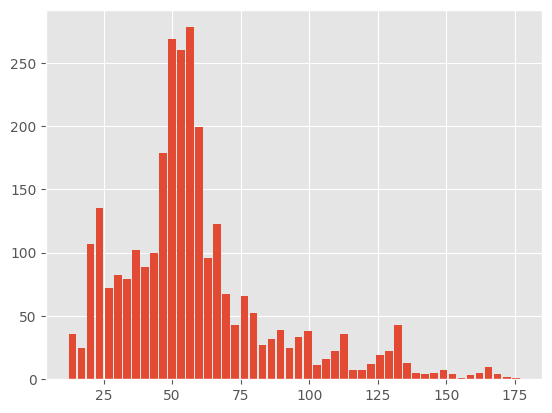

In [9]:
import matplotlib.pyplot as plt

data = EyeBlinkDataset(train=False, use_threshold=0)
data_loader = torch.utils.data.DataLoader(data, batch_size=16, shuffle=True)

print(len(data))

for seqs, labels in data_loader:
    continue

# print(data.sizes)
# tmp = [[x[0],x[1]['fname'],x[1]['size']] for x in enumerate(data.sizes) if x[1]['size'] >= 96]
tmp = [[x[0],x[1]] for x in enumerate(data.sizes) if x[1] >= 96]
print("----",tmp, '----')
print(len(data.sizes))
# counts, bins = np.histogram(data.sizes)
plt.style.use('ggplot')
plt.hist(data.sizes, bins=50, rwidth=0.85)
plt.show()

In [53]:
data = EyeBlinkDataset(train=True)
data_loader = torch.utils.data.DataLoader(data, batch_size=16, shuffle=True)

seq, label = next(iter(data_loader))

model = P2B2_SeparableConv().double()
num_params = sum(param.numel() for param in model.parameters() if param.requires_grad) # only trainable
print(num_params)

seq = seq.permute((0,4,3,1,2))
pred = model(seq)
print(pred)

['datasets/train/training/blink/8', 'datasets/train/training/blink/141', 'datasets/train/training/blink/151', 'datasets/train/training/blink/153', 'datasets/train/training/blink/155', 'datasets/train/training/blink/158', 'datasets/train/training/blink/160', 'datasets/train/training/blink/179', 'datasets/train/training/blink/181', 'datasets/train/training/blink/198', 'datasets/train/training/unblink/55', 'datasets/train/training/unblink/61', 'datasets/train/training/unblink/76', 'datasets/train/training/unblink/78', 'datasets/train/training/unblink/80', 'datasets/train/training/unblink/82', 'datasets/train/training/unblink/93', 'datasets/train/training/unblink/95', 'datasets/train/training/unblink/144', 'datasets/train/training/unblink/146']
58178
tensor([[0.5257, 0.4554],
        [0.1879, 0.0254],
        [0.0493, 0.2270],
        [0.1437, 0.2547],
        [0.1207, 0.1454],
        [0.3567, 0.2765],
        [0.3173, 0.2719],
        [0.4734, 0.4015],
        [0.2769, 0.1193],
        [

['datasets/train/training/blink/8', 'datasets/train/training/blink/141', 'datasets/train/training/blink/151', 'datasets/train/training/blink/153', 'datasets/train/training/blink/155', 'datasets/train/training/blink/158', 'datasets/train/training/blink/160', 'datasets/train/training/blink/179', 'datasets/train/training/blink/181', 'datasets/train/training/blink/198', 'datasets/train/training/unblink/55', 'datasets/train/training/unblink/61', 'datasets/train/training/unblink/76', 'datasets/train/training/unblink/78', 'datasets/train/training/unblink/80', 'datasets/train/training/unblink/82', 'datasets/train/training/unblink/93', 'datasets/train/training/unblink/95', 'datasets/train/training/unblink/144', 'datasets/train/training/unblink/146']
5460


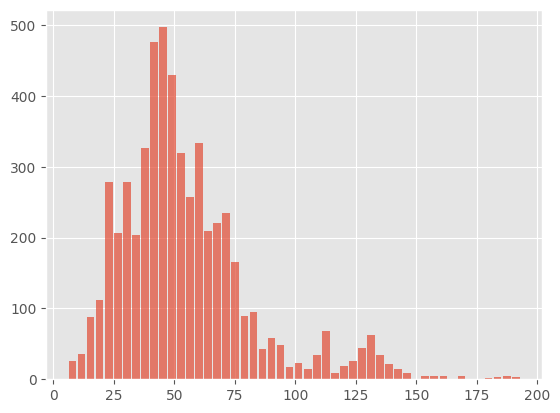

In [51]:
import matplotlib.pyplot as plt

data = EyeBlinkDataset(train=True)
data_loader = torch.utils.data.DataLoader(data, batch_size=16, shuffle=True)

for seqs, labels in data_loader:
    continue

# print(data.sizes)
print(len(data.sizes))
# counts, bins = np.histogram(data.sizes)
plt.style.use('ggplot')
plt.hist(data.sizes, bins=50, rwidth=0.85)
plt.show()

In [85]:
from sklearn.model_selection import KFold

import os
import random
import numpy as np
import torch

def fixed_seed(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set `pytorch` pseudo-random generator at a fixed value
    torch.manual_seed(seed_value)


data = EyeBlinkDataset(train=True)
tmp_loader = torch.utils.data.DataLoader(data, batch_size=16, shuffle=True)
print(len(tmp_loader))

# fixed_seed(42)

print(len(data))

kfold = KFold(n_splits=5, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(data)):
    print(f'Fold {fold}: ')
    # print(f'train_ids: {train_ids}')
    # print(f'val_ids: {val_ids}')
    train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_ids)
    # print(f'train_sampler: {next(iter(train_sampler))}')
    # print(f'val_sampler: {next(iter(val_sampler))}')
    train_loader = torch.utils.data.DataLoader(data, batch_size=16, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(data, batch_size=16, sampler=val_sampler)

    count = 0
    for item_1, item_2 in train_loader:
        # print(len(item))
        print(item_1.shape,item_2.shape)
        count+=1
    print(count)
    count = 0
    for item_1, item_2 in val_loader:
        count+=1
        print(item_1.shape, item_2.shape)
    print(count)

    print(len(train_sampler))
    print(len(val_sampler))
    # print(len(train_loader[0]))
    # print(len(val_loader[0]))


['datasets/train/training/blink/8', 'datasets/train/training/blink/141', 'datasets/train/training/blink/151', 'datasets/train/training/blink/153', 'datasets/train/training/blink/155', 'datasets/train/training/blink/158', 'datasets/train/training/blink/160', 'datasets/train/training/blink/179', 'datasets/train/training/blink/181', 'datasets/train/training/blink/198', 'datasets/train/training/unblink/55', 'datasets/train/training/unblink/61', 'datasets/train/training/unblink/76', 'datasets/train/training/unblink/78', 'datasets/train/training/unblink/80', 'datasets/train/training/unblink/82', 'datasets/train/training/unblink/93', 'datasets/train/training/unblink/95', 'datasets/train/training/unblink/144', 'datasets/train/training/unblink/146']
27
428
Fold 0: 
torch.Size([16, 96, 96, 13, 3]) torch.Size([16])
torch.Size([16, 96, 96, 13, 3]) torch.Size([16])
torch.Size([16, 96, 96, 13, 3]) torch.Size([16])
torch.Size([16, 96, 96, 13, 3]) torch.Size([16])
torch.Size([16, 96, 96, 13, 3]) torch

In [20]:
def count_TP(preds_logits, labels):
    #preds = preds_logits.argmax(dim=1)
    tmp = torch.add(preds_logits, labels)
    return (tmp == 2).sum().item()

def count_TN(preds_logits, labels):
    #preds = preds_logits.argmax(dim=1)
    tmp = torch.add(preds_logits, labels)
    return (tmp == 0).sum().item()

def count_FP(preds_logits, labels):
    #preds = preds_logits.argmax(dim=1)
    tmp = torch.subtract(preds_logits, labels)
    return (tmp == 1).sum().item()

def count_FN(preds_logits, labels):
    #preds = preds_logits.argmax(dim=1)
    tmp = torch.subtract(preds_logits, labels)
    return (tmp == -1).sum().item()

arr1 = torch.Tensor([0,0,1,1,0,1,0,1,1,1,0])
arr2 = torch.Tensor([0,1,1,0,0,1,1,1,0,1,0])
print(count_TP(arr1,arr2))
print(count_TN(arr1,arr2))
print(count_FP(arr1,arr2))
print(count_FN(arr1,arr2))

<built-in function sum>
4
<built-in function sum>
3
<built-in function sum>
2
<built-in function sum>
2


In [4]:
model1 = P2B2().double()
model2 = P2B2_SeparableConv().double()
model3 = P3B3().double()
model4 = P3B3_SeparableConv().double()

num_params = sum(param.numel() for param in model1.parameters() if param.requires_grad) # only trainable
print(num_params)
num_params = sum(param.numel() for param in model2.parameters() if param.requires_grad) # only trainable
print(num_params)
num_params = sum(param.numel() for param in model3.parameters() if param.requires_grad) # only trainable
print(num_params)
num_params = sum(param.numel() for param in model4.parameters() if param.requires_grad) # only trainable
print(num_params)

437442
58178
7583362
455170


In [4]:
data = EyeBlinkDataset(train=True)
data_loader = torch.utils.data.DataLoader(data, batch_size=16, shuffle=True)

print(len(data))

seq, label = next(iter(data_loader))
print(seq)

#for seq, label in data_loader:
#    print(seq.shape)
#    print(label)



# seq_ = seq.permute((0,4,3,1,2))
# print(seq_.shape)
# model = P2B2().double()
# seq_ = model(seq_)
# print(seq_)
# print(seq_.shape)

['datasets/train/training/blink/8', 'datasets/train/training/blink/141', 'datasets/train/training/blink/151', 'datasets/train/training/blink/153', 'datasets/train/training/blink/155', 'datasets/train/training/blink/158', 'datasets/train/training/blink/160', 'datasets/train/training/blink/179', 'datasets/train/training/blink/181', 'datasets/train/training/blink/198', 'datasets/train/training/unblink/55', 'datasets/train/training/unblink/61', 'datasets/train/training/unblink/76', 'datasets/train/training/unblink/78', 'datasets/train/training/unblink/80', 'datasets/train/training/unblink/82', 'datasets/train/training/unblink/93', 'datasets/train/training/unblink/95', 'datasets/train/training/unblink/144', 'datasets/train/training/unblink/146']
428
tensor([[[[[0.1843, 0.1176, 0.0863],
           [0.1843, 0.1176, 0.0863],
           [0.1961, 0.1255, 0.0980],
           ...,
           [0.2000, 0.1255, 0.1020],
           [0.1922, 0.1373, 0.0941],
           [0.1922, 0.1373, 0.0941]],

     

['datasets/train/training/blink/8', 'datasets/train/training/blink/141', 'datasets/train/training/blink/151', 'datasets/train/training/blink/153', 'datasets/train/training/blink/155', 'datasets/train/training/blink/158', 'datasets/train/training/blink/160', 'datasets/train/training/blink/179', 'datasets/train/training/blink/181', 'datasets/train/training/blink/198', 'datasets/train/training/unblink/55', 'datasets/train/training/unblink/61', 'datasets/train/training/unblink/76', 'datasets/train/training/unblink/78', 'datasets/train/training/unblink/80', 'datasets/train/training/unblink/82', 'datasets/train/training/unblink/93', 'datasets/train/training/unblink/95', 'datasets/train/training/unblink/144', 'datasets/train/training/unblink/146']


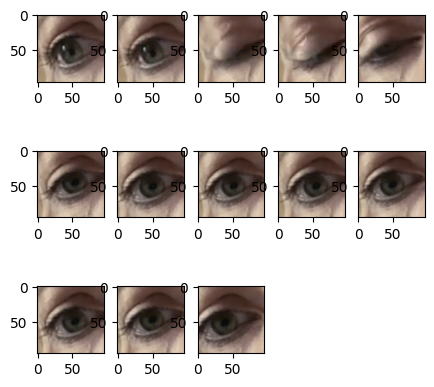

torch.Size([16, 96, 96, 13, 3])
torch.Size([16, 3, 13, 96, 96])
torch.Size([16, 64, 7, 96, 96])
torch.Size([16, 64, 4, 96, 96])
torch.Size([16, 64, 4, 48, 48])
torch.Size([16, 64, 1, 1, 1])
torch.Size([16, 64])
tensor([[-0.2923,  0.0033],
        [ 0.1952, -0.3001],
        [-0.1977, -0.1335],
        [-0.1878, -0.1265],
        [-0.0150, -0.1348],
        [-0.0646, -0.0888],
        [-0.0077, -0.2171],
        [-0.0121, -0.2385],
        [-0.0279, -0.2462],
        [-0.0685, -0.1611],
        [ 0.0223, -0.1528],
        [ 0.0178, -0.1747],
        [-0.1238, -0.1717],
        [-0.2035, -0.1850],
        [-0.2284, -0.1847],
        [-0.2527, -0.1699]], dtype=torch.float64, grad_fn=<AddmmBackward0>)


In [2]:
import torch.nn as nn
import matplotlib.pyplot as plt

data = EyeBlinkDataset(train=True)
data_loader = torch.utils.data.DataLoader(data, batch_size=16)
seq, label = next(iter(data_loader))
def display_seq(seq):
    plt.figure(figsize=(5,5))
    for i in range(seq.shape[3]):
        plt.subplot(3,5,i+1)
        img = seq[5,:,:,i,:3]
        plt.imshow(img.astype(int))
    plt.show()

# print(len(data))
# print(seq[3,:,:,:,:])

# tmp = seq[0,:,:,0,:].numpy()
# print(tmp.shape)

display_seq(seq.numpy())
print(seq.shape)
seq_ = seq.permute((0,4,3,1,2))
print(seq_.shape)

class Conv(nn.Module):
    def __init__(self):
        super(Conv, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=64, kernel_size=(3,3,3), stride=(2,1,1), padding=(1,1,1))
        self.batchnorm = nn.BatchNorm3d(num_features=64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool3d(kernel_size=(3,3,3), stride=(2,1,1), padding=(1,1,1))
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3,1,1), stride=(1,2,2), padding=(1,0,0))
        self.avgpool = nn.AvgPool3d(kernel_size=(4,48,48))
        self.linear = nn.Linear(64,2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        print(x.shape)
        x= self.maxpool(x)
        print(x.shape)
        x = self.conv2(x)
        print(x.shape)
        x = self.avgpool(x)
        print(x.shape)
        x = x.squeeze()
        print(x.shape)
        x = self.linear(x)
        return x

model = Conv().double()
seq_ = model(seq_)
print(seq_)

# seq__ = model(seq.permute((0,4,3,1,2)))
# tmp = torch.add(seq_, seq__)
# print("seq_: ", seq_)
# print("seq__: ", seq__)
# print("tmp: ", tmp)
# print(seq_.shape)
# print(seq__.shape)
# print(tmp.shape)

# print(seq__)
# print(seq_.shape)

# display_seq(seq_.permute((0,3,4,2,1)).detach().numpy())

In [17]:
tmp = torch.randn(20, 16, 10, 50, 100)
print(tmp.dtype)

torch.float32


# end